In [3]:
from google.colab import files
uploaded = files.upload()  # Upload epl_player_stats_24_25.csv

In [5]:
import pandas as pd

df = pd.read_csv('epl_player_stats_24_25.csv', encoding='utf-8-sig')
print("Shape:", df.shape)
print("\nPositions in dataset:", df['Position'].value_counts())
df.head()

Shape: (562, 57)

Positions in dataset: Position
MID    229
DEF    202
FWD     86
GKP     45
Name: count, dtype: int64


,Player Name,Club,Nationality,Position,Appearances,Minutes,Goals,Assists,Shots,Shots On Target,...,Fouls,Yellow Cards,Red Cards,Saves,Saves %,Penalties Saved,Clearances Off Line,Punches,High Claims,Goals Prevented
0,Ben White,Arsenal,England,DEF,17,1198,0,2,9,12,...,10,2,0,0,0%,0,0,0,0,0.0
1,Bukayo Saka,Arsenal,England,MID,25,1735,6,10,67,2,...,15,3,0,0,0%,0,0,0,0,0.0
2,David Raya,Arsenal,Spain,GKP,38,3420,0,0,0,0,...,1,3,0,86,72%,0,0,8,53,2.1
3,Declan Rice,Arsenal,England,MID,35,2833,4,7,48,18,...,21,5,1,0,0%,0,0,0,0,0.0
4,Ethan Nwaneri,Arsenal,England,MID,26,889,4,0,24,0,...,9,1,0,0,0%,0,0,0,0,0.0


In [6]:
# This tells us which columns have missing/empty data
missing = df.isnull().sum()
print(missing[missing > 0])  # Only show columns that have missing values

Series([], dtype: int64)


Data Cleaning


In [7]:
# First let's see what % columns look like - they have % signs which makes them text not numbers
# We need to convert them to actual numbers

percent_cols = ['Conversion %', 'Passes%', 'Crosses %', 'fThird Passes %', 'gDuels %', 'aDuels %', 'Saves %']

for col in percent_cols:
    df[col] = df[col].astype(str).str.replace('%', '').str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' turns anything weird into NaN

# Fill missing values with 0 (a player with no saves simply has 0, not unknown)
df.fillna(0, inplace=True)

print("Any missing values left?", df.isnull().sum().sum())  # Should print 0
print("\nData types now:")
print(df.dtypes)

Any missing values left? 0

Data types now:
Player Name                   object
Club                          object
Nationality                   object
Position                      object
Appearances                    int64
Minutes                        int64
Goals                          int64
Assists                        int64
Shots                          int64
Shots On Target                int64
Conversion %                   int64
Big Chances Missed             int64
Hit Woodwork                   int64
Offsides                       int64
Touches                        int64
Passes                         int64
Successful Passes              int64
Passes%                        int64
Crosses                        int64
Successful Crosses             int64
Crosses %                      int64
fThird Passes                  int64
Successful fThird Passes       int64
fThird Passes %                int64
Through Balls                  int64
Carries                        

Feature Engineering


In [8]:
# We create new per-90 stats so players with fewer minutes aren't unfairly penalized
# A player with 5 goals in 500 mins is better than 5 goals in 2000 mins

df['Goals_p90']             = (df['Goals'] / df['Minutes']) * 90
df['Assists_p90']           = (df['Assists'] / df['Minutes']) * 90
df['Shots_p90']             = (df['Shots'] / df['Minutes']) * 90
df['Tackles_p90']           = (df['Tackles'] / df['Minutes']) * 90
df['Interceptions_p90']     = (df['Interceptions'] / df['Minutes']) * 90
df['Progressive Carries_p90'] = (df['Progressive Carries'] / df['Minutes']) * 90
df['Passes_p90']            = (df['Passes'] / df['Minutes']) * 90
df['Touches_p90']           = (df['Touches'] / df['Minutes']) * 90

# Replace any infinity values (happens if Minutes = 0) with 0
import numpy as np
df.replace([np.inf, -np.inf], 0, inplace=True)

# Filter to players with at least 450 mins (5 full games) to remove noise from rare appearances
df = df[df['Minutes'] >= 450].reset_index(drop=True)

print(f"Players remaining after minutes filter: {len(df)}")
print(f"\nPosition breakdown:\n{df['Position'].value_counts()}")

Players remaining after minutes filter: 397

Position breakdown:
Position
MID    174
DEF    144
FWD     46
GKP     33
Name: count, dtype: int64


EDA Visualization

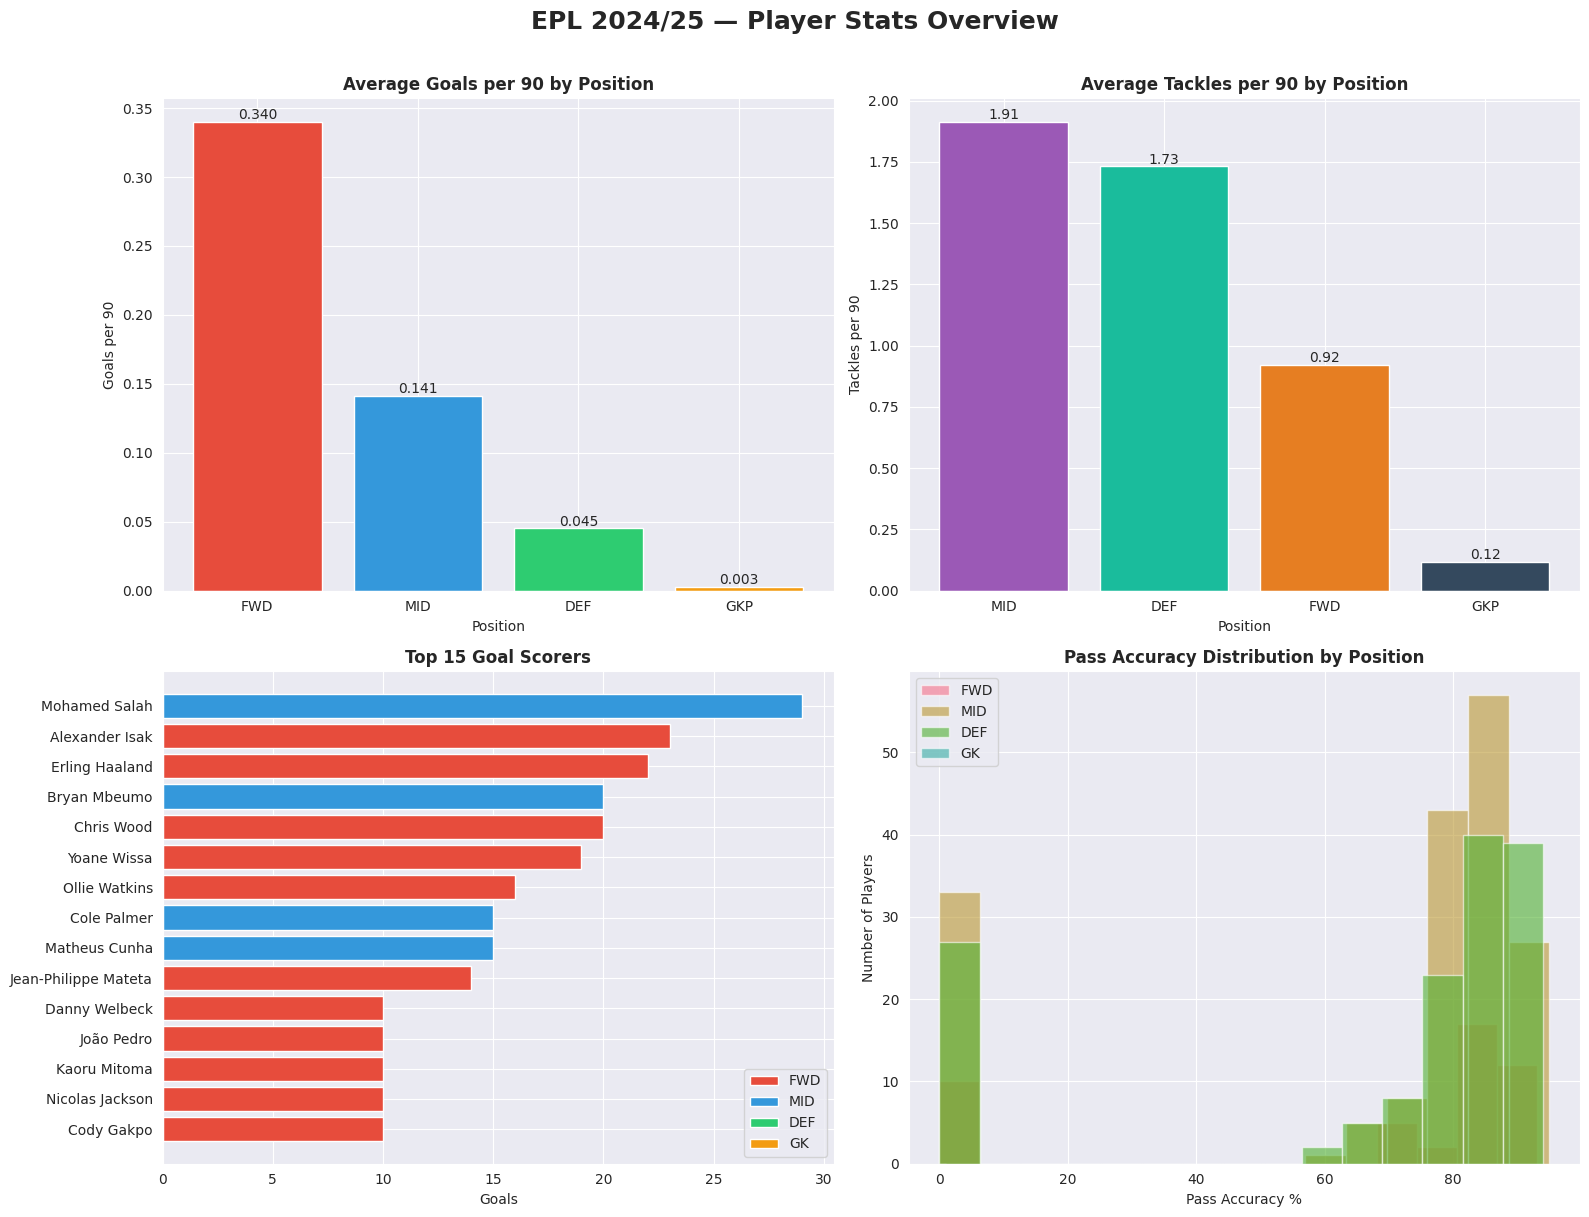

Chart saved!


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('EPL 2024/25 — Player Stats Overview', fontsize=18, fontweight='bold', y=1.01)

# --- Plot 1: Goals by Position ---
ax1 = axes[0, 0]
position_goals = df.groupby('Position')['Goals_p90'].mean().sort_values(ascending=False)
bars = ax1.bar(position_goals.index, position_goals.values, color=['#e74c3c','#3498db','#2ecc71','#f39c12'])
ax1.set_title('Average Goals per 90 by Position', fontweight='bold')
ax1.set_xlabel('Position')
ax1.set_ylabel('Goals per 90')
for bar, val in zip(bars, position_goals.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.3f}', ha='center', fontsize=10)

# --- Plot 2: Tackles by Position ---
ax2 = axes[0, 1]
position_tackles = df.groupby('Position')['Tackles_p90'].mean().sort_values(ascending=False)
bars2 = ax2.bar(position_tackles.index, position_tackles.values, color=['#9b59b6','#1abc9c','#e67e22','#34495e'])
ax2.set_title('Average Tackles per 90 by Position', fontweight='bold')
ax2.set_xlabel('Position')
ax2.set_ylabel('Tackles per 90')
for bar, val in zip(bars2, position_tackles.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.2f}', ha='center', fontsize=10)

# --- Plot 3: Top 15 Goal Scorers ---
ax3 = axes[1, 0]
top_scorers = df.nlargest(15, 'Goals')[['Player Name', 'Goals', 'Position']]
colors_map = {'FWD': '#e74c3c', 'MID': '#3498db', 'DEF': '#2ecc71', 'GK': '#f39c12'}
bar_colors = [colors_map.get(p, 'gray') for p in top_scorers['Position']]
ax3.barh(top_scorers['Player Name'], top_scorers['Goals'], color=bar_colors)
ax3.set_title('Top 15 Goal Scorers', fontweight='bold')
ax3.set_xlabel('Goals')
ax3.invert_yaxis()
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=v, label=k) for k, v in colors_map.items()]
ax3.legend(handles=legend_elements, loc='lower right')

# --- Plot 4: Pass Accuracy Distribution ---
ax4 = axes[1, 1]
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    subset = df[df['Position'] == pos]['Passes%']
    ax4.hist(subset, bins=15, alpha=0.6, label=pos)
ax4.set_title('Pass Accuracy Distribution by Position', fontweight='bold')
ax4.set_xlabel('Pass Accuracy %')
ax4.set_ylabel('Number of Players')
ax4.legend()

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved!")

EDA Chelsea Midfielders Focus


In [11]:
# --- Isolate Chelsea Midfielders ---
chelsea_mids = df[(df['Club'] == 'Chelsea') & (df['Position'] == 'MID')].copy()

print(f"Chelsea Midfielders found: {len(chelsea_mids)}")
print(chelsea_mids[['Player Name', 'Appearances', 'Minutes', 'Goals', 'Assists']].to_string(index=False))

Chelsea Midfielders found: 8
       Player Name  Appearances  Minutes  Goals  Assists
Christopher Nkunku           27      911      3        0
       Cole Palmer           37     3195     15        8
    Enzo Fernández           36     2946      6        7
      Jadon Sancho           31     1764      3        0
    Moisés Caicedo           38     3356      1        2
      Noni Madueke           32     2046      7        3
        Pedro Neto           35     2268      4        0
       Roméo Lavia           16      801      0        1


Chelsea Midfielders: Radar Chart (the best viz for comparing players)


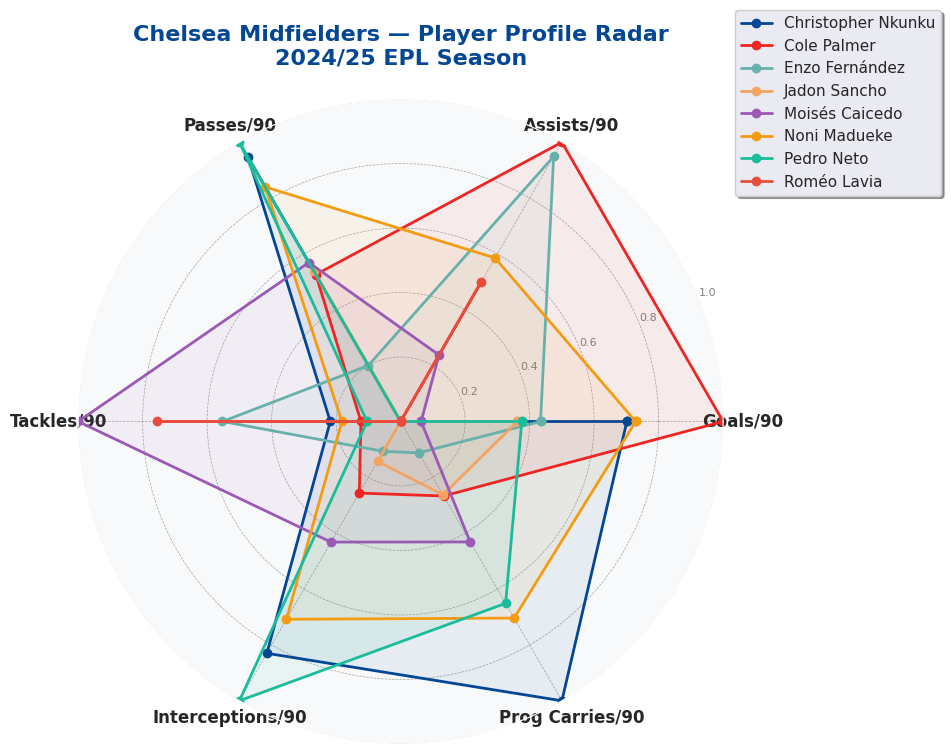

Radar chart saved!


In [12]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import numpy as np

# Pick the key stats to compare midfielders on
categories = ['Goals_p90', 'Assists_p90', 'Passes_p90', 'Tackles_p90',
              'Interceptions_p90', 'Progressive Carries_p90']

labels = ['Goals/90', 'Assists/90', 'Passes/90', 'Tackles/90', 'Interceptions/90', 'Prog Carries/90']

# Normalize each stat to 0-1 scale so radar chart is fair
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
chelsea_mids_scaled = chelsea_mids.copy()
chelsea_mids_scaled[categories] = scaler.fit_transform(chelsea_mids[categories])

# --- Draw radar chart ---
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # close the circle

chelsea_colors = ['#034694', '#EE2523', '#68B0AB', '#F4A460', '#9B59B6', '#F39C12',
                  '#1ABC9C', '#E74C3C', '#2ECC71', '#3498DB']

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('#ffffff')

for i, (_, row) in enumerate(chelsea_mids_scaled.iterrows()):
    values = row[categories].tolist()
    values += values[:1]
    color = chelsea_colors[i % len(chelsea_colors)]
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label=row['Player Name'])
    ax.fill(angles, values, alpha=0.07, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8, color='grey')
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

ax.set_title('Chelsea Midfielders — Player Profile Radar\n2024/25 EPL Season',
             size=16, fontweight='bold', pad=25, color='#034694')

ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.15), fontsize=11,
          frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('chelsea_mids_radar.png', dpi=150, bbox_inches='tight')
plt.show()
print("Radar chart saved!")

Chelsea Midfielders: Bar Chart Comparison


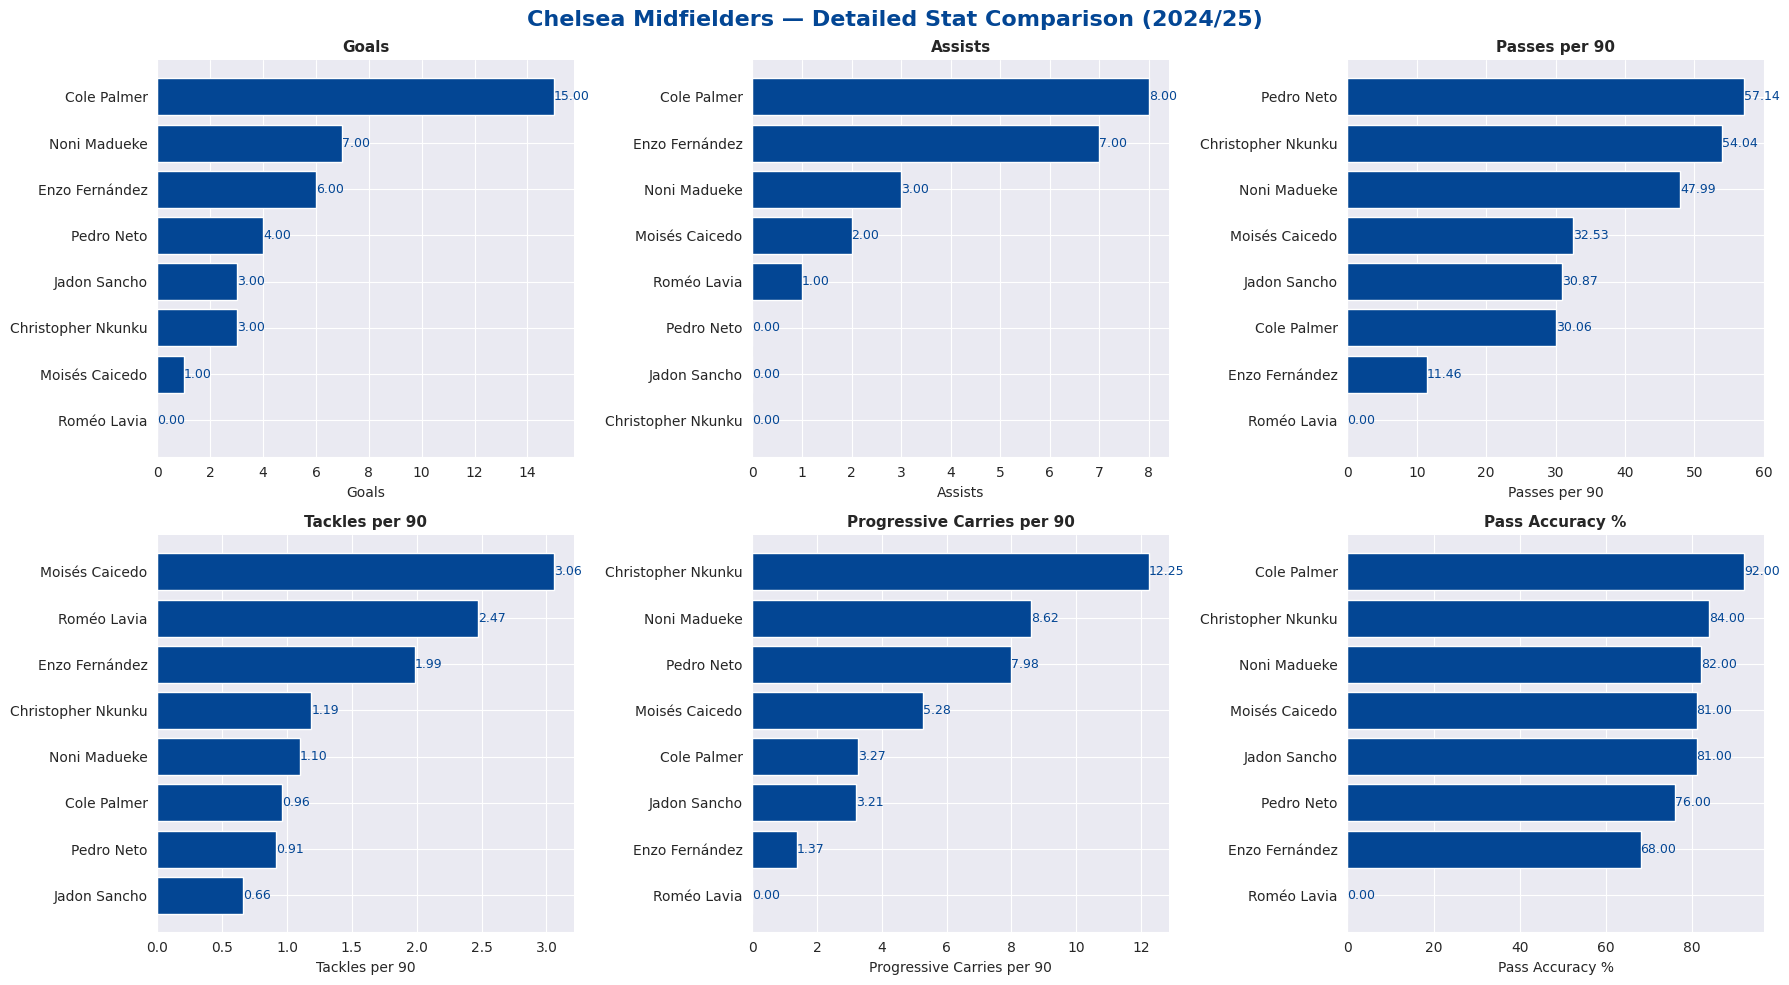

Bar chart saved!


In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Chelsea Midfielders — Detailed Stat Comparison (2024/25)',
             fontsize=16, fontweight='bold', color='#034694')

stat_pairs = [
    ('Goals', 'Goals'),
    ('Assists', 'Assists'),
    ('Passes_p90', 'Passes per 90'),
    ('Tackles_p90', 'Tackles per 90'),
    ('Progressive Carries_p90', 'Progressive Carries per 90'),
    ('Passes%', 'Pass Accuracy %')
]

chelsea_palette = ['#034694'] * len(chelsea_mids)

for ax, (stat, title) in zip(axes.flatten(), stat_pairs):
    sorted_df = chelsea_mids.sort_values(stat, ascending=True)
    bars = ax.barh(sorted_df['Player Name'], sorted_df[stat], color='#034694', edgecolor='white')
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_xlabel(title)
    # Add value labels on bars
    for bar, val in zip(bars, sorted_df[stat]):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', fontsize=9, color='#034694')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('chelsea_mids_bars.png', dpi=150, bbox_inches='tight')
plt.show()
print("Bar chart saved!")

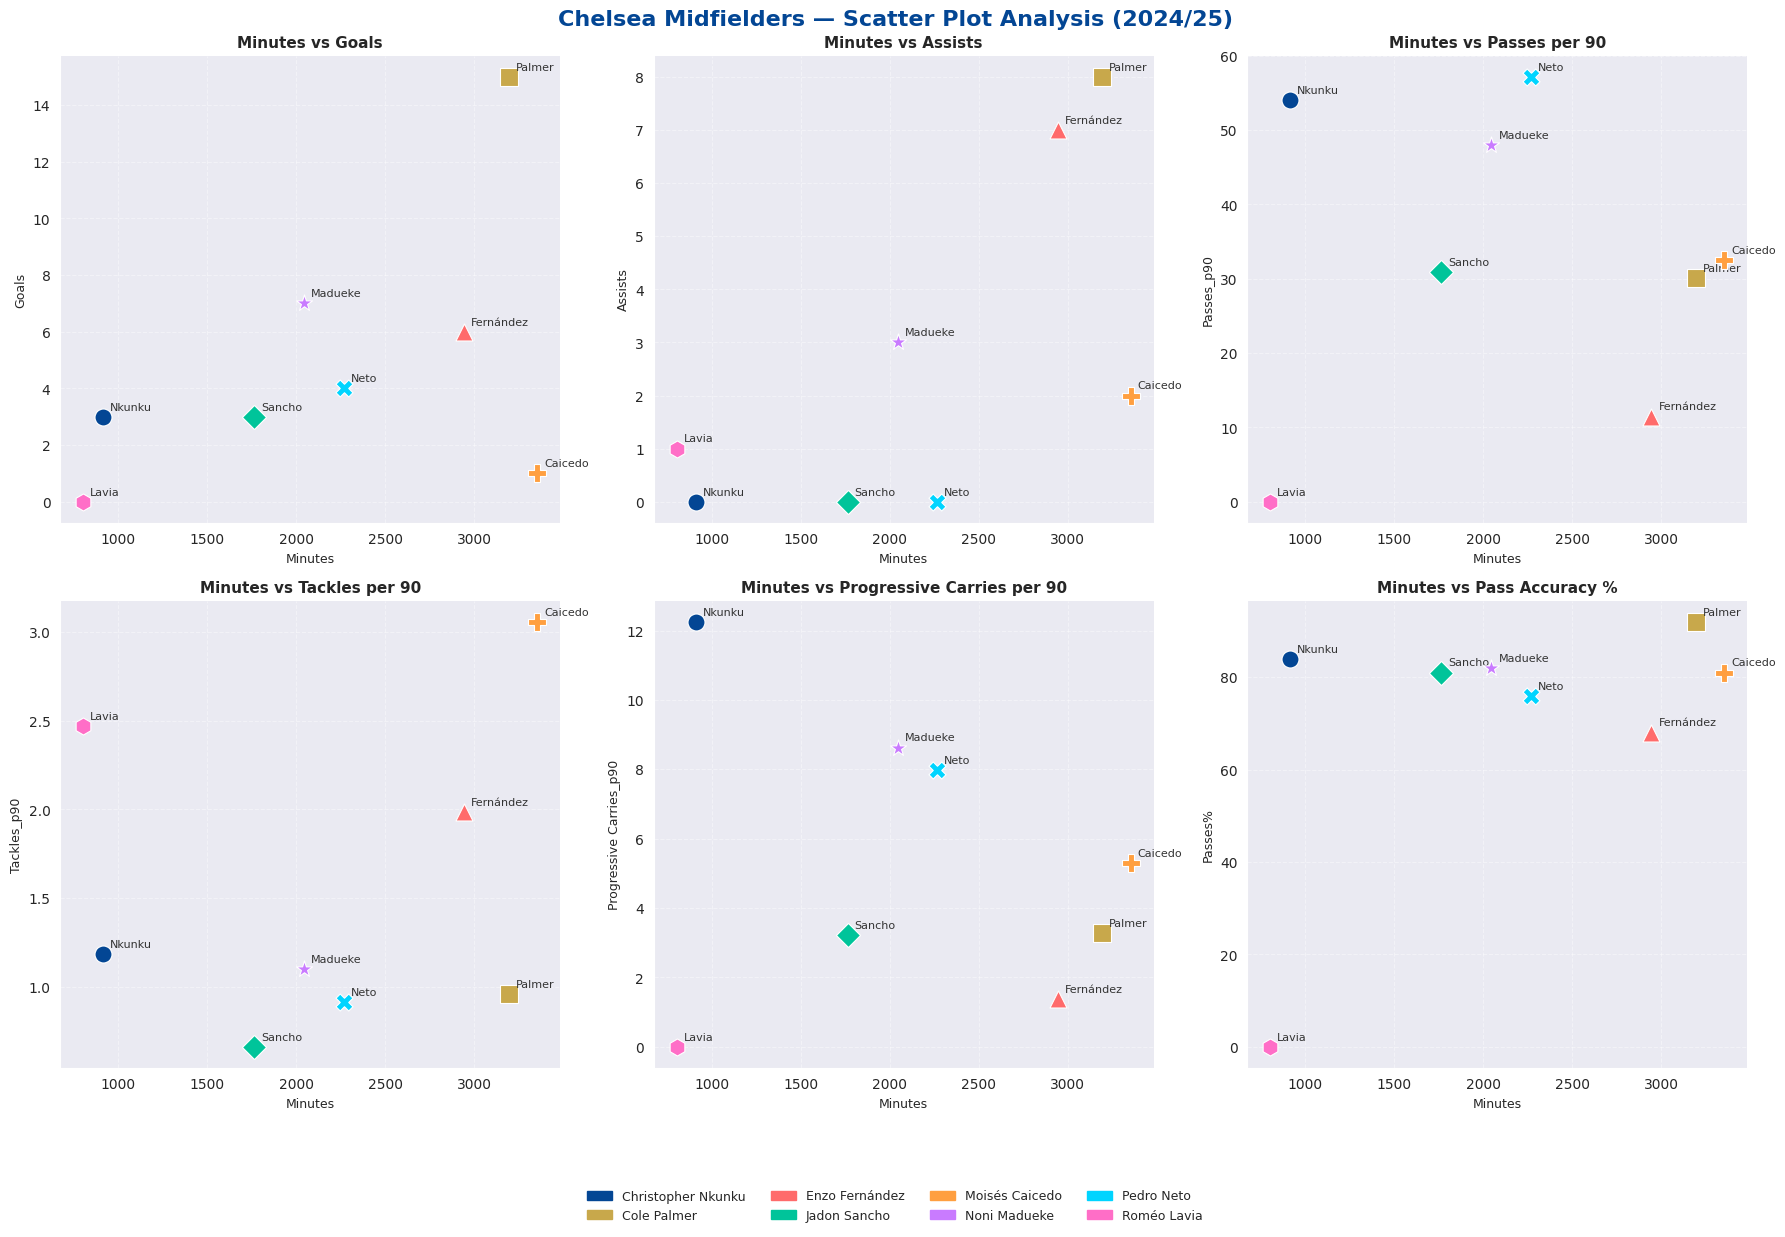

Scatter plot saved!


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Chelsea Midfielders — Scatter Plot Analysis (2024/25)',
             fontsize=16, fontweight='bold', color='#034694')

# Assign each player a unique color and marker
colors = ['#034694', '#C8A84B', '#FF6B6B', '#00C49A', '#FF9F40', '#C97BFF', '#00D4FF', '#FF6EC7']
markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'h']

players = chelsea_mids['Player Name'].tolist()

# Each scatter plot: x = Minutes played, y = the stat (so you can see output relative to playing time)
scatter_pairs = [
    ('Minutes', 'Goals',                    'Minutes vs Goals'),
    ('Minutes', 'Assists',                  'Minutes vs Assists'),
    ('Minutes', 'Passes_p90',               'Minutes vs Passes per 90'),
    ('Minutes', 'Tackles_p90',              'Minutes vs Tackles per 90'),
    ('Minutes', 'Progressive Carries_p90',  'Minutes vs Progressive Carries per 90'),
    ('Minutes', 'Passes%',                  'Minutes vs Pass Accuracy %'),
]

for ax, (x_stat, y_stat, title) in zip(axes.flatten(), scatter_pairs):
    for i, (_, row) in enumerate(chelsea_mids.iterrows()):
        ax.scatter(
            row[x_stat], row[y_stat],
            color=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            s=150,
            edgecolors='white',
            linewidths=0.8,
            zorder=3
        )
        # Label each dot with the player's last name
        last_name = row['Player Name'].split()[-1]
        ax.annotate(
            last_name,
            xy=(row[x_stat], row[y_stat]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            color='#333333'
        )

    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_xlabel(x_stat, fontsize=9)
    ax.set_ylabel(y_stat, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.4)

# Shared legend at the bottom
legend_handles = [
    mpatches.Patch(color=colors[i % len(colors)], label=name)
    for i, name in enumerate(players)
]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=4,
    fontsize=9,
    frameon=False,
    bbox_to_anchor=(0.5, -0.04)
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('chelsea_mids_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print("Scatter plot saved!")

Model Selection & Training


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ── What are we predicting? ──────────────────────────────────────────
# TARGET: Position (GKP, DEF, MID, FWD) — this is a Classification task
# FEATURES: All the per-90 stats we engineered earlier

# Step 1: Drop rows where Position is missing
model_df = df.dropna(subset=['Position']).copy()

# Step 2: Select only numeric feature columns (our per-90 stats + raw counts)
feature_cols = [
    'Goals', 'Assists', 'Shots', 'Shots On Target',
    'Passes_p90', 'Tackles_p90', 'Progressive Carries_p90',
    'Passes%', 'Interceptions', 'Clearances', 'Saves',
    'Goals Conceded', 'Touches', 'Fouls', 'Yellow Cards'
]

X = model_df[feature_cols].fillna(0)   # Features (what the model learns FROM)
y = model_df['Position']               # Target  (what the model is trying to PREDICT)

# Step 3: Encode the target — ML models need numbers, not text
# GKP → 0, DEF → 1, FWD → 2, MID → 3
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)         # Shows you the mapping

# Step 4: Scale the features so no single stat dominates
# e.g. Touches (2000) would overpower Goals (15) without scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split — 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,       # Makes split reproducible
    stratify=y_encoded     # Ensures each position is represented in both sets
)

print(f"\nTraining samples : {X_train.shape[0]}")
print(f"Testing  samples : {X_test.shape[0]}")

Classes: ['DEF' 'FWD' 'GKP' 'MID']

Training samples : 317
Testing  samples : 80


This is training three models  to compare them


In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# We train 3 different algorithms and see which performs best
# Think of it like asking 3 different analysts to solve the same problem

models = {
    'Logistic Regression' : LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest'       : RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting'   : GradientBoostingClassifier(n_estimators=100, random_state=42),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)                          # Train on training set
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc  = accuracy_score(y_test,  model.predict(X_test))
    results[name] = {'train': train_acc, 'test': test_acc, 'model': model}
    print(f"{name:25s} → Train: {train_acc:.2%}  |  Test: {test_acc:.2%}")

Logistic Regression       → Train: 90.54%  |  Test: 86.25%
Random Forest             → Train: 100.00%  |  Test: 82.50%
Gradient Boosting         → Train: 100.00%  |  Test: 80.00%


Evaluation, this is deep  evaluation of the best model

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pick the best model based on test accuracy
best_name = max(results, key=lambda k: results[k]['test'])
best_model = results[best_name]['model']
print(f"Best model: {best_name}\n")

y_pred = best_model.predict(X_test)

# ── Classification Report ────────────────────────────────────────────
# Precision: Of all players the model called "FWD", how many actually were?
# Recall:    Of all actual FWDs, how many did the model correctly find?
# F1:        Balance between Precision and Recall
print(classification_report(y_test, y_pred, target_names=le.classes_))

Best model: Logistic Regression

              precision    recall  f1-score   support

         DEF       0.87      0.90      0.88        29
         FWD       0.88      0.78      0.82         9
         GKP       0.88      1.00      0.93         7
         MID       0.85      0.83      0.84        35

    accuracy                           0.86        80
   macro avg       0.87      0.88      0.87        80
weighted avg       0.86      0.86      0.86        80



onfusion matrix (the most visual way to see where the model makes mistakes):

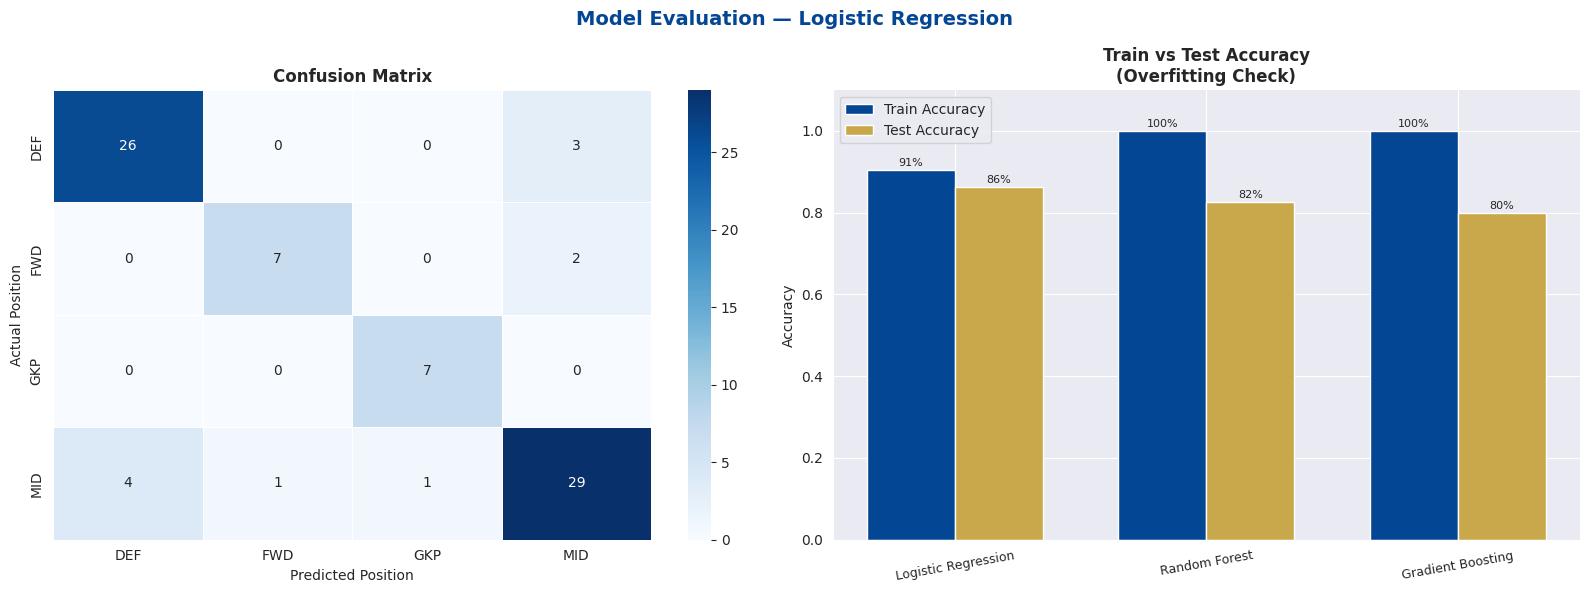

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Model Evaluation — {best_name}', fontsize=14, fontweight='bold', color='#034694')

# ── LEFT: Confusion Matrix ───────────────────────────────────────────
# Rows = Actual position, Columns = Predicted position
# Perfect model = all numbers on the diagonal
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=le.classes_, yticklabels=le.classes_,
    ax=axes[0], linewidths=0.5
)
axes[0].set_title('Confusion Matrix', fontweight='bold')
axes[0].set_xlabel('Predicted Position')
axes[0].set_ylabel('Actual Position')

# ── RIGHT: Train vs Test Accuracy (Overfitting Check) ────────────────
# If Train >> Test, the model memorized instead of learning
names  = list(results.keys())
trains = [results[n]['train'] for n in names]
tests  = [results[n]['test']  for n in names]
x = np.arange(len(names))
w = 0.35

bars1 = axes[1].bar(x - w/2, trains, w, label='Train Accuracy', color='#034694')
bars2 = axes[1].bar(x + w/2, tests,  w, label='Test Accuracy',  color='#C8A84B')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names, rotation=10, fontsize=9)
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Train vs Test Accuracy\n(Overfitting Check)', fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Value labels on bars
for bar in bars1:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{bar.get_height():.0%}', ha='center', fontsize=8)
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{bar.get_height():.0%}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Only works for Random Forest and Gradient Boosting
if best_name in ['Random Forest', 'Gradient Boosting']:
    importances = best_model.feature_importances_
    feat_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
    feat_df = feat_df.sort_values('Importance', ascending=True)

    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.barh(feat_df['Feature'], feat_df['Importance'], color='#034694', edgecolor='white')
    ax.set_title(f'Feature Importance — {best_name}\n(Which stats help predict position the most?)',
                 fontweight='bold', fontsize=12, color='#034694')
    ax.set_xlabel('Importance Score')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for bar, val in zip(bars, feat_df['Importance']):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=9, color='#034694')

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saves and Goals Conceded should rank high — those are goalkeeper-only stats!")

Deployemnt: This is to predict a real Player

In [23]:
# This is your "deployment" — feeding new data into the trained model

def predict_player_position(player_name):
    # Find the player in the dataset
    player_row = df[df['Player Name'].str.lower() == player_name.lower()]

    if player_row.empty:
        print(f"Player '{player_name}' not found in dataset.")
        return

    # Extract their features
    player_features = player_row[feature_cols].fillna(0)
    player_scaled   = scaler.transform(player_features)   # Use the SAME scaler from training

    # Predict
    pred_encoded  = best_model.predict(player_scaled)
    pred_position = le.inverse_transform(pred_encoded)[0]
    actual_position = player_row['Position'].values[0]

    # Get probability for each position
    probs = best_model.predict_proba(player_scaled)[0]

    print(f"\nPlayer  : {player_row['Player Name'].values[0]}")
    print(f"Actual  : {actual_position}")
    print(f"Predicted: {pred_position}")
    print(f"\nConfidence breakdown:")
    for cls, prob in zip(le.classes_, probs):
        bar = '█' * int(prob * 30)
        print(f"  {cls:4s}  {bar:30s}  {prob:.1%}")

# Try it on some players!
predict_player_position("Cole Palmer")
#predict_player_position("Caicedo")
predict_player_position("Erling Haaland")


Player  : Cole Palmer
Actual  : MID
Predicted: MID

Confidence breakdown:
  DEF                                   0.0%
  FWD   ████                            14.1%
  GKP                                   0.0%
  MID   █████████████████████████       85.9%

Player  : Erling Haaland
Actual  : FWD
Predicted: FWD

Confidence breakdown:
  DEF                                   0.0%
  FWD   █████████████████████████████   99.6%
  GKP                                   0.0%
  MID                                   0.4%


IN  THIS PART CLUSTERING TO GROUP PLAYERS IN THEIR POSITIONS

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# For clustering we IGNORE position — the model figures out groups on its own
# We use stats that capture different styles of play

cluster_features = [
    'Goals', 'Assists', 'Shots', 'Shots On Target',
    'Passes_p90', 'Tackles_p90', 'Progressive Carries_p90',
    'Passes%', 'Interceptions', 'Clearances',
    'Saves', 'Touches', 'Fouls', 'Crosses'
]

# Filter to players with 450+ minutes (5 full games) to avoid noise
cluster_df = df[df['Minutes'] >= 450].copy()
cluster_df = cluster_df.dropna(subset=cluster_features)
cluster_df[cluster_features] = cluster_df[cluster_features].fillna(0)

X_cluster = cluster_df[cluster_features].values

# Scale the data — essential for K-Means
scaler_c = StandardScaler()
X_scaled_c = scaler_c.fit_transform(X_cluster)

print(f"Players going into clustering: {len(cluster_df)}")

Players going into clustering: 397


Find the optimal number of clusters (Elbow Method)

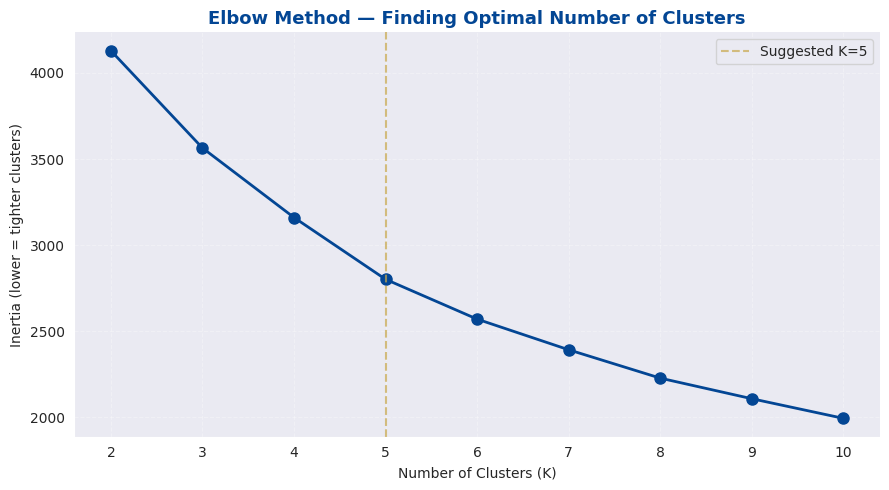

In [24]:
# The Elbow Method helps us pick K
# We try K = 2 to 10 and look for where the improvement starts to flatten

inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled_c)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(K_range, inertias, 'o-', color='#034694', linewidth=2, markersize=8)
ax.axvline(x=5, color='#C8A84B', linestyle='--', alpha=0.7, label='Suggested K=5')
ax.set_title('Elbow Method — Finding Optimal Number of Clusters',
             fontweight='bold', fontsize=13, color='#034694')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia (lower = tighter clusters)')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('elbow_method.png', dpi=150, bbox_inches='tight')
plt.show()

# The "elbow" — where the curve bends — is your ideal K
# Look at the chart and note which K value has the sharpest bend

Train K-Means with =5

In [25]:
# K=5 makes football sense:
# Cluster 0 → Goalkeepers
# Cluster 1 → Defensive players (CBs, holding mids)
# Cluster 2 → Creative midfielders / playmakers
# Cluster 3 → Wingers / attacking mids
# Cluster 4 → Strikers / forwards

K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_df['Cluster'] = kmeans.fit_predict(X_scaled_c)

# See what position mix is inside each cluster
print("=== Position breakdown per cluster ===\n")
print(pd.crosstab(cluster_df['Cluster'], cluster_df['Position']))

# See the top players in each cluster
print("\n=== Sample players per cluster ===\n")
for c in range(K):
    players_in = cluster_df[cluster_df['Cluster'] == c]['Player Name'].head(6).tolist()
    print(f"Cluster {c}: {', '.join(players_in)}")

=== Position breakdown per cluster ===

Position  DEF  FWD  GKP  MID
Cluster                     
0           0    0   21    1
1          69    1    1   45
2          27   10   11   32
3          48   16    0   56
4           0   19    0   40

=== Sample players per cluster ===

Cluster 0: David Raya, Emiliano Martínez, Kepa, Mark Flekken, Bart Verbruggen, Robert Sánchez
Cluster 1: Gabriel Magalhães, Jurriën Timber, Thomas Partey, William Saliba, Amadou Onana, Ezri Konsa
Cluster 2: Ethan Nwaneri, Gabriel Jesus, Jorginho, Oleksandr Zinchenko, Raheem Sterling, Axel Disasi
Cluster 3: Ben White, Jakub Kiwior, Mikel Merino, Myles Lewis-Skelly, Riccardo Calafiori, Boubacar Kamara
Cluster 4: Bukayo Saka, Declan Rice, Gabriel Martinelli, Kai Havertz, Leandro Trossard, Martin Ødegaard


Visualize with PCA Scatter Plot


PCA captured 46.9% of total variance


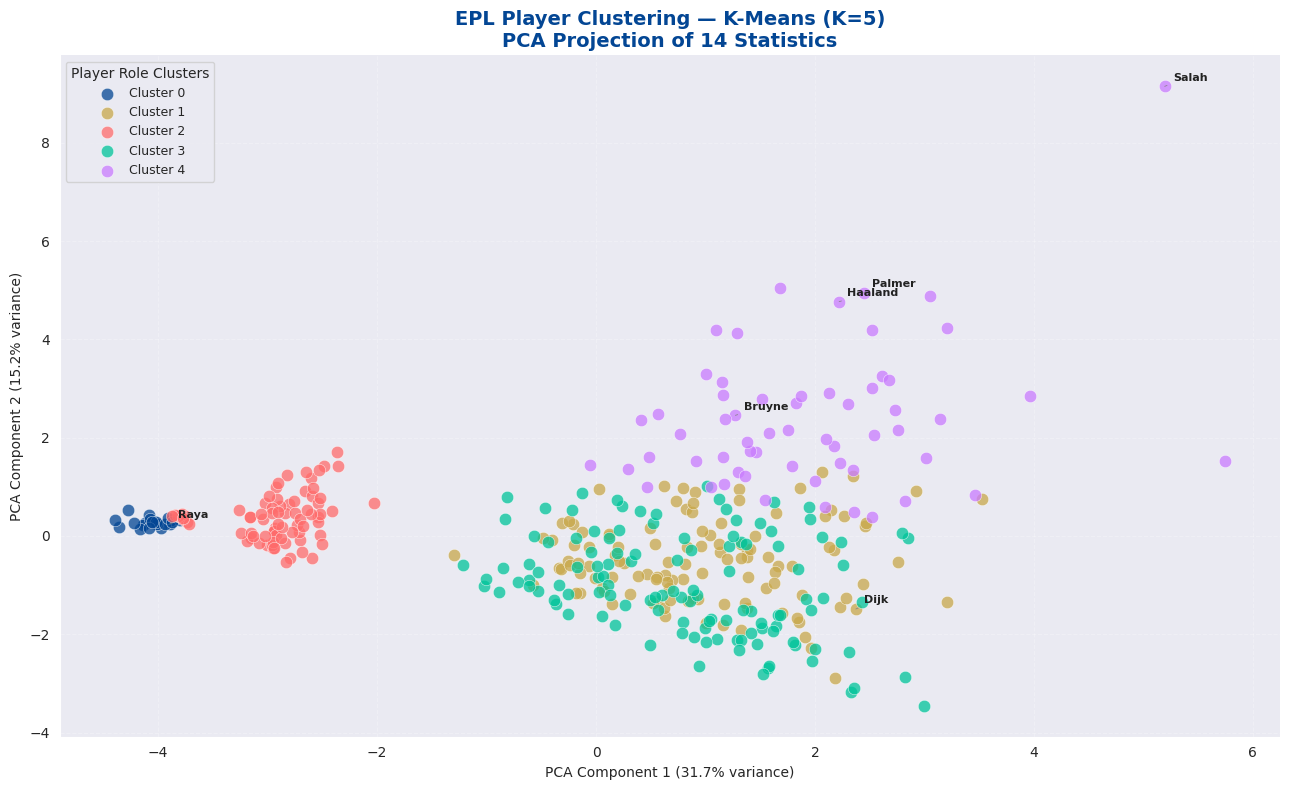

In [26]:
# K-Means clusters in 14 dimensions — impossible to visualise directly
# PCA compresses 14 dimensions down to 2 so we can plot it
# Think of it as taking a photo of a 3D object — you lose some info but can now see it

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_c)

cluster_df['PCA1'] = X_pca[:, 0]
cluster_df['PCA2'] = X_pca[:, 1]

# Explained variance — how much info PCA kept
var1, var2 = pca.explained_variance_ratio_
print(f"PCA captured {var1+var2:.1%} of total variance")

# Cluster labels — you'll rename these after seeing the position breakdown above
cluster_labels = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3',
    4: 'Cluster 4'
}

colors_k = ['#034694', '#C8A84B', '#FF6B6B', '#00C49A', '#C97BFF']

fig, ax = plt.subplots(figsize=(13, 8))

for c in range(K):
    mask = cluster_df['Cluster'] == c
    ax.scatter(
        cluster_df.loc[mask, 'PCA1'],
        cluster_df.loc[mask, 'PCA2'],
        c=colors_k[c],
        label=cluster_labels[c],
        s=80, alpha=0.75,
        edgecolors='white', linewidths=0.4
    )

# Label a few standout players
highlight = ['Cole Palmer', 'Erling Haaland', 'Virgil van Dijk',
             'David Raya', 'Kevin De Bruyne', 'Mohamed Salah']

for _, row in cluster_df[cluster_df['Player Name'].isin(highlight)].iterrows():
    ax.annotate(
        row['Player Name'].split()[-1],
        xy=(row['PCA1'], row['PCA2']),
        xytext=(6, 4), textcoords='offset points',
        fontsize=8, fontweight='bold',
        color='#222222',
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
    )

ax.set_title('EPL Player Clustering — K-Means (K=5)\nPCA Projection of 14 Statistics',
             fontsize=14, fontweight='bold', color='#034694')
ax.set_xlabel(f'PCA Component 1 ({var1:.1%} variance)', fontsize=10)
ax.set_ylabel(f'PCA Component 2 ({var2:.1%} variance)', fontsize=10)
ax.legend(title='Player Role Clusters', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout()
plt.savefig('kmeans_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

Rename the scatter plots after visualizing

In [27]:
# After running Cell 3, look at the position breakdown and rename accordingly
# For example if Cluster 0 is mostly GKP, rename it "Goalkeepers"

cluster_labels = {
    0: 'Goalkeepers',
    1: 'Defensive Players',
    2: 'Creative Midfielders',
    3: 'Wingers / Attackers',
    4: 'Strikers'
}

cluster_df['Role'] = cluster_df['Cluster'].map(cluster_labels)

# Final summary table
print(cluster_df.groupby('Role')[['Goals', 'Assists', 'Tackles_p90',
                                    'Passes_p90', 'Saves']].mean().round(2))

                      Goals  Assists  Tackles_p90  Passes_p90  Saves
Role                                                                
Creative Midfielders   0.94     0.46         1.60        0.00   3.46
Defensive Players      1.63     1.54         2.03       29.69   0.00
Goalkeepers            0.00     0.14         0.03        0.00  90.95
Strikers               8.29     5.08         1.09       35.71   0.00
Wingers / Attackers    1.52     0.94         1.67       67.98   0.00


Finding the top most creative midfielders in the league

In [29]:
# ── STEP 1: Diagnose why Passes_p90 is 0 ─────────────────────────
print(cluster_df[['Player Name', 'Passes', 'Minutes', 'Passes_p90']].head(10))

# If Passes_p90 is missing, recalculate it now
cluster_df['Passes_p90'] = (cluster_df['Passes'] / cluster_df['Minutes']) * 90
cluster_df['Progressive Carries_p90'] = (cluster_df['Progressive Carries'] / cluster_df['Minutes']) * 90
cluster_df['Tackles_p90'] = (cluster_df['Tackles'] / cluster_df['Minutes']) * 90

print("\nAfter fix:")
print(cluster_df[['Player Name', 'Passes_p90', 'Progressive Carries_p90']].head(5))

          Player Name  Passes  Minutes  Passes_p90
0           Ben White    1678     1198  126.060100
1         Bukayo Saka     643     1735   33.354467
2          David Raya       0     3420    0.000000
3         Declan Rice     789     2833   25.065302
4       Ethan Nwaneri       0      889    0.000000
5       Gabriel Jesus       0      603    0.000000
6   Gabriel Magalhães     590     2365   22.452431
7  Gabriel Martinelli     344     2300   13.460870
8        Jakub Kiwior     533     1117   42.945389
9            Jorginho       0      702    0.000000

After fix:
     Player Name  Passes_p90  Progressive Carries_p90
0      Ben White  126.060100                22.237062
1    Bukayo Saka   33.354467                 3.579251
2     David Raya    0.000000                 0.000000
3    Declan Rice   25.065302                 8.259795
4  Ethan Nwaneri    0.000000                 0.000000


In [30]:
# ── Define role profiles using stat thresholds ────────────────────
# Box-to-Box: high tackles + decent goals/assists + good passes
# CAM:        high goals + high assists + high progressive carries
# CM:         high passes + high pass accuracy + moderate tackles

mids_only = cluster_df[cluster_df['Position'] == 'MID'].copy()

# Recalculate per-90 stats just to be safe
mids_only['Passes_p90']              = (mids_only['Passes'] / mids_only['Minutes']) * 90
mids_only['Progressive Carries_p90'] = (mids_only['Progressive Carries'] / mids_only['Minutes']) * 90
mids_only['Tackles_p90']             = (mids_only['Tackles'] / mids_only['Minutes']) * 90

# ── Score each player for each role ──────────────────────────────
mids_only['CAM_Score'] = (
    mids_only['Goals'] * 3 +
    mids_only['Assists'] * 3 +
    mids_only['Progressive Carries_p90'] * 2 +
    mids_only['Shots'] * 1
)

mids_only['CM_Score'] = (
    mids_only['Passes_p90'] * 3 +
    mids_only['Passes%'] * 2 +
    mids_only['Tackles_p90'] * 1 +
    mids_only['Touches'] * 0.01
)

mids_only['B2B_Score'] = (
    mids_only['Tackles_p90'] * 3 +
    mids_only['Goals'] * 2 +
    mids_only['Assists'] * 2 +
    mids_only['Passes_p90'] * 1 +
    mids_only['Interceptions'] * 1
)

# ── Assign each player their best fitting role ───────────────────
def assign_role(row):
    scores = {
        'CAM'         : row['CAM_Score'],
        'CM'          : row['CM_Score'],
        'Box-to-Box'  : row['B2B_Score'],
    }
    return max(scores, key=scores.get)

mids_only['Mid_Role'] = mids_only.apply(assign_role, axis=1)

# ── Print top 5 per role ──────────────────────────────────────────
for role, score_col in [('CAM', 'CAM_Score'), ('CM', 'CM_Score'), ('Box-to-Box', 'B2B_Score')]:
    top = mids_only[mids_only['Mid_Role'] == role].sort_values(score_col, ascending=False).head(5)
    print(f"\n=== TOP {role}s ===")
    print(f"{'Player':<25} {'Club':<22} {'Goals':<8} {'Assists':<10} {'Pass/90':<10} {'Tackles/90':<12} {'ProgCarries/90'}")
    print("-" * 95)
    for _, row in top.iterrows():
        print(f"{row['Player Name']:<25} {row['Club']:<22} "
              f"{row['Goals']:<8.0f} {row['Assists']:<10.0f} "
              f"{row['Passes_p90']:<10.1f} {row['Tackles_p90']:<12.1f} "
              f"{row['Progressive Carries_p90']:.1f}")


=== TOP CAMs ===
Player                    Club                   Goals    Assists    Pass/90    Tackles/90   ProgCarries/90
-----------------------------------------------------------------------------------------------
Mohamed Salah             Liverpool              29       18         20.5       0.6          6.2
Carlos Alcaraz            Everton                2        3          0.0        1.3          0.0
Ethan Nwaneri             Arsenal                4        0          0.0        1.1          0.0
Ross Barkley              Aston Villa            3        1          0.0        2.2          0.0
Brajan Gruda              Brighton & Hove Albion 1        4          0.0        2.1          0.0

=== TOP CMs ===
Player                    Club                   Goals    Assists    Pass/90    Tackles/90   ProgCarries/90
-----------------------------------------------------------------------------------------------
David Brooks              Bournemouth            2        0          151

In [31]:
# ── STEP 1: Check what's missing ─────────────────────────────────
print("Missing values in key columns:")
print(mids_only[['Passes', 'Progressive Carries', 'Tackles']].isnull().sum())

# Fix: use the raw columns directly and recalculate carefully
# Some players have 0 in Passes because the dataset stores it differently
print("\nSample of players with 0 passes:")
print(mids_only[mids_only['Passes'] == 0][['Player Name', 'Passes', 'Touches', 'Minutes']].head(10))

Missing values in key columns:
Passes                 0
Progressive Carries    0
Tackles                0
dtype: int64

Sample of players with 0 passes:
         Player Name  Passes  Touches  Minutes
4      Ethan Nwaneri       0      601      889
9           Jorginho       0      550      702
17   Raheem Sterling       0      300      496
40      Ross Barkley       0      493      569
44        Alex Scott       0      523      751
69    Mathias Jensen       0      601      852
79      Brajan Gruda       0      394      681
82       Diego Gómez       0      422      512
112      Roméo Lavia       0      526      801
127   Justin Devenny       0      288      496


In [32]:
# ── STEP 2: Recalculate properly, replace 0s with NaN first ──────
import numpy as np

cols_to_fix = ['Passes', 'Progressive Carries', 'Tackles', 'Interceptions']
for col in cols_to_fix:
    mids_only[col] = mids_only[col].replace(0, np.nan)

# Now recalculate per-90 — players with missing data get NaN not 0
mids_only['Passes_p90']              = (mids_only['Passes'] / mids_only['Minutes']) * 90
mids_only['Progressive Carries_p90'] = (mids_only['Progressive Carries'] / mids_only['Minutes']) * 90
mids_only['Tackles_p90']             = (mids_only['Tackles'] / mids_only['Minutes']) * 90

# Fill remaining NaN with 0 for scoring
mids_only[['Passes_p90', 'Progressive Carries_p90', 'Tackles_p90']] = \
    mids_only[['Passes_p90', 'Progressive Carries_p90', 'Tackles_p90']].fillna(0)

In [33]:
# ── STEP 3: Recalculate role scores ──────────────────────────────
mids_only['CAM_Score'] = (
    mids_only['Goals'] * 3 +
    mids_only['Assists'] * 3 +
    mids_only['Progressive Carries_p90'] * 2 +
    mids_only['Shots'] * 1
)

mids_only['CM_Score'] = (
    mids_only['Passes_p90'] * 3 +
    mids_only['Passes%'].fillna(0) * 2 +
    mids_only['Tackles_p90'] * 1 +
    mids_only['Touches'].fillna(0) * 0.01
)

mids_only['B2B_Score'] = (
    mids_only['Tackles_p90'] * 3 +
    mids_only['Goals'] * 2 +
    mids_only['Assists'] * 2 +
    mids_only['Passes_p90'] * 1 +
    mids_only['Interceptions'].fillna(0) * 1
)

# Reassign roles
mids_only['Mid_Role'] = mids_only.apply(assign_role, axis=1)

print(f"Total midfielders: {len(mids_only)}")
print(mids_only['Mid_Role'].value_counts())

Total midfielders: 174
Mid_Role
CM            143
CAM            27
Box-to-Box      4
Name: count, dtype: int64


In [34]:
# ── STEP 4: Print ALL midfielders per role ───────────────────────
pd.set_option('display.max_rows', 200)

for role, score_col in [('CAM', 'CAM_Score'), ('CM', 'CM_Score'), ('Box-to-Box', 'B2B_Score')]:
    top = mids_only[mids_only['Mid_Role'] == role].sort_values(score_col, ascending=False)
    print(f"\n{'='*95}")
    print(f"  {role} — {len(top)} players")
    print(f"{'='*95}")
    print(f"{'Rank':<5} {'Player':<25} {'Club':<22} {'Goals':<7} {'Assists':<9} {'Pass/90':<10} {'Tackles/90':<12} {'ProgCarries/90'}")
    print("-" * 95)
    for i, (_, row) in enumerate(top.iterrows(), 1):
        print(f"{i:<5} {row['Player Name']:<25} {row['Club']:<22} "
              f"{row['Goals']:<7.0f} {row['Assists']:<9.0f} "
              f"{row['Passes_p90']:<10.1f} {row['Tackles_p90']:<12.1f} "
              f"{row['Progressive Carries_p90']:.1f}")


  CAM — 27 players
Rank  Player                    Club                   Goals   Assists   Pass/90    Tackles/90   ProgCarries/90
-----------------------------------------------------------------------------------------------
1     Mohamed Salah             Liverpool              29      18        20.5       0.6          6.2
2     Carlos Alcaraz            Everton                2       3         0.0        1.3          0.0
3     Ethan Nwaneri             Arsenal                4       0         0.0        1.1          0.0
4     Ross Barkley              Aston Villa            3       1         0.0        2.2          0.0
5     Brajan Gruda              Brighton & Hove Albion 1       4         0.0        2.1          0.0
6     Pablo Sarabia             Wolverhampton Wanderers 3       0         0.0        1.8          0.0
7     Jaden Philogene           Ipswich Town           2       0         0.0        2.8          0.0
8     Mason Mount               Manchester United      1       0

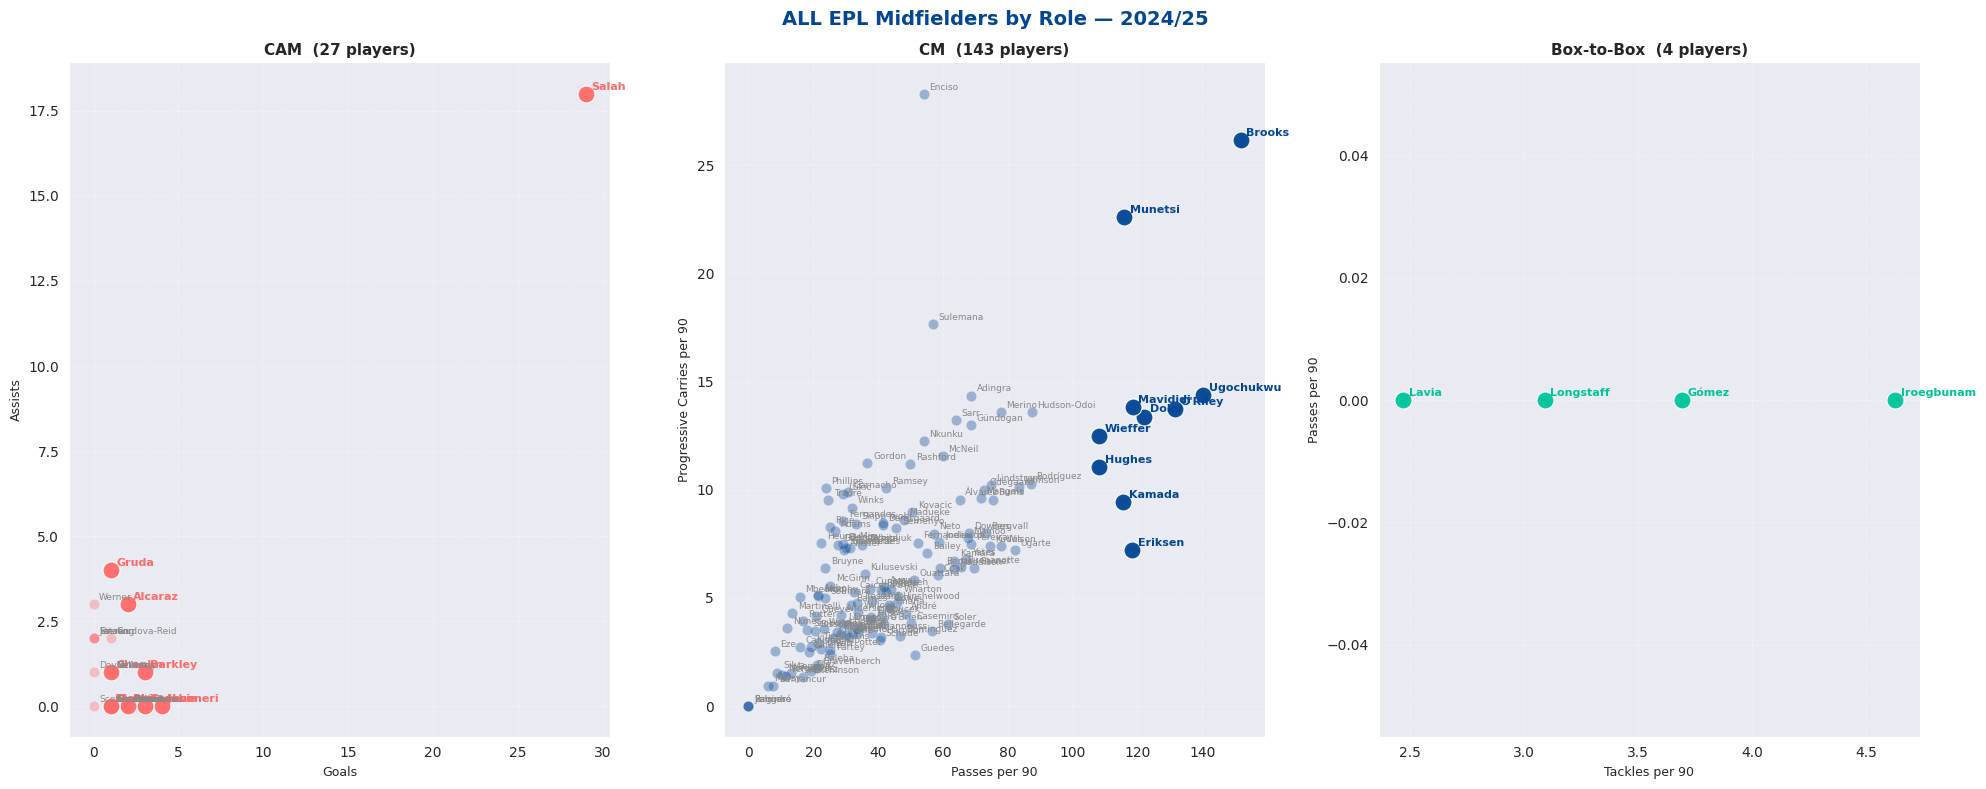

In [35]:
# ── STEP 5: Full scatter plot — ALL midfielders labeled ──────────
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('ALL EPL Midfielders by Role — 2024/25',
             fontsize=14, fontweight='bold', color='#034694')

role_config = [
    ('CAM',        'CAM_Score',  'Goals',       'Assists',                 '#FF6B6B', 'Goals',         'Assists'),
    ('CM',         'CM_Score',   'Passes_p90',  'Progressive Carries_p90', '#034694', 'Passes per 90', 'Progressive Carries per 90'),
    ('Box-to-Box', 'B2B_Score',  'Tackles_p90', 'Passes_p90',              '#00C49A', 'Tackles per 90','Passes per 90'),
]

for ax, (role, score_col, x_col, y_col, color, xlabel, ylabel) in zip(axes, role_config):
    role_df = mids_only[mids_only['Mid_Role'] == role].sort_values(score_col, ascending=False)
    top10   = role_df.head(10)

    # All players in role
    ax.scatter(
        role_df[x_col], role_df[y_col],
        color=color, s=55, alpha=0.35,
        edgecolors='white', linewidths=0.3
    )

    # Top 10 bold
    ax.scatter(
        top10[x_col], top10[y_col],
        color=color, s=150, alpha=0.95,
        edgecolors='white', linewidths=0.8,
        zorder=3
    )

    # Label EVERY player (small font)
    for _, row in role_df.iterrows():
        is_top10 = row['Player Name'] in top10['Player Name'].values
        ax.annotate(
            row['Player Name'].split()[-1],
            xy=(row[x_col], row[y_col]),
            xytext=(4, 3), textcoords='offset points',
            fontsize=6.5 if not is_top10 else 8,
            fontweight='bold' if is_top10 else 'normal',
            color=color if is_top10 else '#888888'
        )

    ax.set_title(f'{role}  ({len(role_df)} players)', fontweight='bold', fontsize=11)
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('all_midfielder_roles.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipython-input-638/2750335638.py:138: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-638/2750335638.py:138: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-638/2750335638.py:138: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-638/2750335638.py:139: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig('progressive_midfielders.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
/tmp/ipython-input-638/2750335638.py:139: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('progressive_midfielders.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
/tmp/ipython-input-638/2750335638.py:139: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('progressive_midfielders.png', 

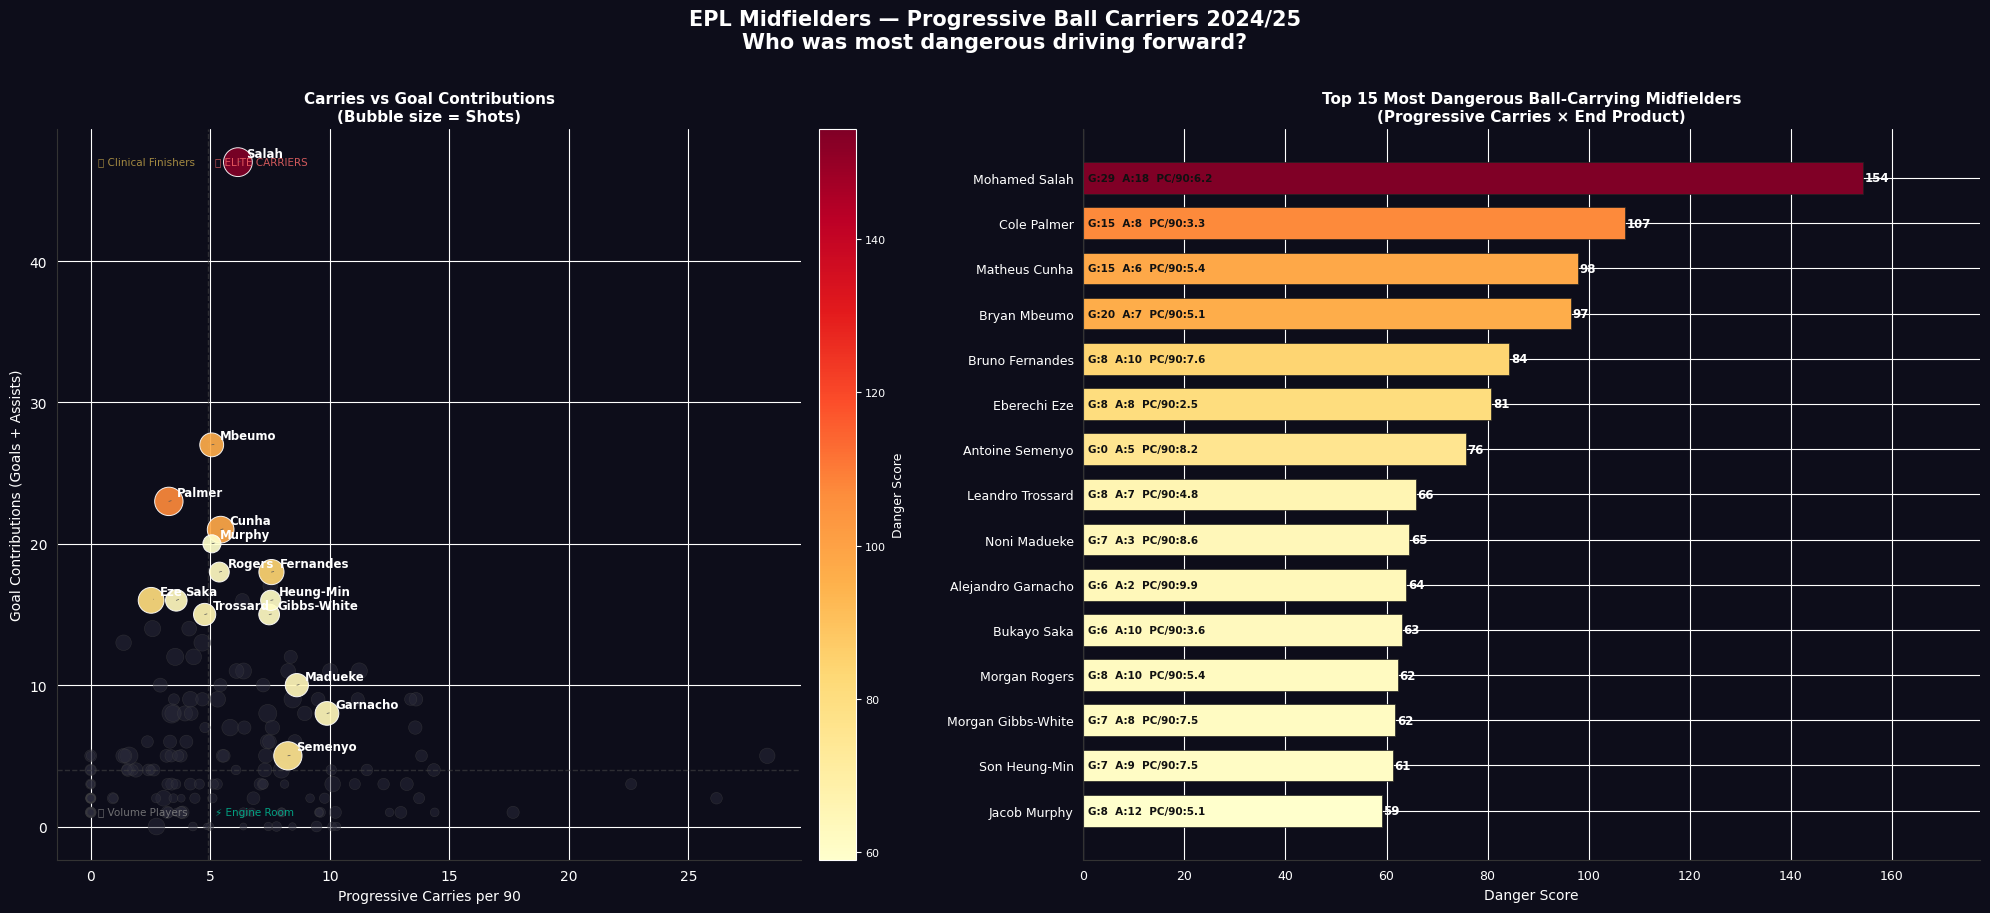

Saved!


In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define prog_df based on midfielders who progress the ball
prog_df = mids_only[
    (mids_only['Progressive Carries_p90'] > 0) | \
    (mids_only['Goals'] > 0) | \
    (mids_only['Assists'] > 0)
].copy()

# Calculate a 'Danger_Score' for progressive players
prog_df['Danger_Score'] = (
    prog_df['Progressive Carries_p90'] * 0.7 +
    prog_df['Goals'] * 2 +
    prog_df['Assists'] * 1.5 +
    prog_df['Shots'] * 0.5
)

prog_df = prog_df.sort_values('Danger_Score', ascending=False).reset_index(drop=True)

top15 = prog_df.head(15)
rest  = prog_df.iloc[15:]

fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.patch.set_facecolor('#0d0d1a')
fig.suptitle('EPL Midfielders — Progressive Ball Carriers 2024/25\nWho was most dangerous driving forward?',
             fontsize=15, fontweight='bold', color='white', y=1.01)

# ────────────────────────────────────────────────────────────────────
# LEFT PANEL — Bubble chart: Prog Carries vs Goal Contributions
#              Bubble size = Shots | Color = Danger Score
# ────────────────────────────────────────────────────────────────────
ax1 = axes[0]
ax1.set_facecolor('#0d0d1a')

# Background players — grey
ax1.scatter(
    rest['Progressive Carries_p90'],
    rest['Goals'] + rest['Assists'],
    s=rest['Shots'] * 2 + 20,
    color='#2a2a3a', alpha=0.5,
    edgecolors='#444', linewidths=0.4,
    zorder=1
)

# Top 15 — colored by danger score
norm   = mcolors.Normalize(vmin=top15['Danger_Score'].min(), vmax=top15['Danger_Score'].max())
cmap   = plt.cm.YlOrRd
colors = [cmap(norm(s)) for s in top15['Danger_Score']]

sc = ax1.scatter(
    top15['Progressive Carries_p90'],
    top15['Goals'] + top15['Assists'],
    s=top15['Shots'] * 3 + 40,
    color=colors, alpha=0.92,
    edgecolors='white', linewidths=0.7,
    zorder=3
)

# Label top 15
for _, row in top15.iterrows():
    ax1.annotate(
        row['Player Name'].split()[-1],
        xy=(row['Progressive Carries_p90'], row['Goals'] + row['Assists']),
        xytext=(6, 4), textcoords='offset points',
        fontsize=8.5, fontweight='bold',
        color='white',
        arrowprops=dict(arrowstyle='-', color='#555', lw=0.5)
    )

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, pad=0.02)
cbar.set_label('Danger Score', color='white', fontsize=9)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white', fontsize=8)

# Quadrant lines — split into 4 zones
med_x = prog_df['Progressive Carries_p90'].median()
med_y = (prog_df['Goals'] + prog_df['Assists']).median()
ax1.axvline(med_x, color='#444', linestyle='--', lw=1, alpha=0.6)
ax1.axhline(med_y, color='#444', linestyle='--', lw=1, alpha=0.6)

# Quadrant labels
ax1.text(med_x + 0.3, ax1.get_ylim()[1] * 0.95, '🔥 ELITE CARRIERS', fontsize=7.5, color='#FF6B6B', alpha=0.8)
ax1.text(0.3,          ax1.get_ylim()[1] * 0.95, '🎯 Clinical Finishers', fontsize=7.5, color='#C8A84B', alpha=0.8)
ax1.text(med_x + 0.3,  med_y * 0.2,              '⚡ Engine Room', fontsize=7.5, color='#00C49A', alpha=0.8)
ax1.text(0.3,           med_y * 0.2,              '📊 Volume Players', fontsize=7.5, color='#888', alpha=0.8)

ax1.set_xlabel('Progressive Carries per 90', color='white', fontsize=10)
ax1.set_ylabel('Goal Contributions (Goals + Assists)', color='white', fontsize=10)
ax1.set_title('Carries vs Goal Contributions\n(Bubble size = Shots)', color='white', fontsize=11, fontweight='bold')
ax1.tick_params(colors='white')
ax1.spines['bottom'].set_color('#333')
ax1.spines['left'].set_color('#333')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ────────────────────────────────────────────────────────────────────
# RIGHT PANEL — Horizontal bar race: Top 15 by Danger Score
# ────────────────────────────────────────────────────────────────────
ax2 = axes[1]
ax2.set_facecolor('#0d0d1a')

bar_colors = [cmap(norm(s)) for s in top15['Danger_Score']]
bars = ax2.barh(
    top15['Player Name'][::-1],
    top15['Danger_Score'][::-1],
    color=bar_colors[::-1],
    edgecolor='#222', linewidth=0.5,
    height=0.7
)

# Club tag + stats on each bar
for bar, (_, row) in zip(bars, top15[::-1].iterrows()):
    w = bar.get_width()
    # Danger score at end of bar
    ax2.text(w + 0.3, bar.get_y() + bar.get_height()/2,
             f'{w:.0f}', va='center', fontsize=8.5,
             color='white', fontweight='bold')
    # Stats inside bar
    ax2.text(1, bar.get_y() + bar.get_height()/2,
             f"G:{row['Goals']:.0f}  A:{row['Assists']:.0f}  PC/90:{row['Progressive Carries_p90']:.1f}",
             va='center', fontsize=7.5, color='#111', fontweight='bold')

ax2.set_xlabel('Danger Score', color='white', fontsize=10)
ax2.set_title('Top 15 Most Dangerous Ball-Carrying Midfielders\n(Progressive Carries × End Product)',
              color='white', fontsize=11, fontweight='bold')
ax2.tick_params(colors='white', labelsize=9)
ax2.spines['bottom'].set_color('#333')
ax2.spines['left'].set_color('#333')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim(0, top15['Danger_Score'].max() * 1.15)

plt.tight_layout()
plt.savefig('progressive_midfielders.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
plt.show()
print("Saved!")